# Exploratory Data Analysis

## Import Library

In [112]:
# Data
import pandas as pd
import numpy as np
import sqlite3

# Dates
from datetime import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from scipy import stats

# Path
from pathlib import Path

# Warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
                      
pd.set_option('display.max_columns', None)

## Import Data

In [229]:
# Load dataset
db = sqlite3.connect("../data/score.db")
cursor = db.cursor()
data = pd.read_sql_query(sql="SELECT * from score", con=db)

# Get number of rows and columns
print(data.shape)

# Data preview
data.head()

(15900, 18)


,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green
2,2,0,Yes,None,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport,yellow
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow


In [230]:
# Drop index
data.drop(['index', 'student_id'], axis=1, inplace=True)

In [231]:
data.shape

(15900, 16)

## Target

Let's begin by exploring the target distribution
- The distribution looks Gaussian, which is ideal because normal distributions are mathematically well-behaved and stable. Models built on normally distributed data are generally easier to train and less prone to convergence issues. Furthermore, many statistical models assume normal distribution and this the results more reliable and interpretable.

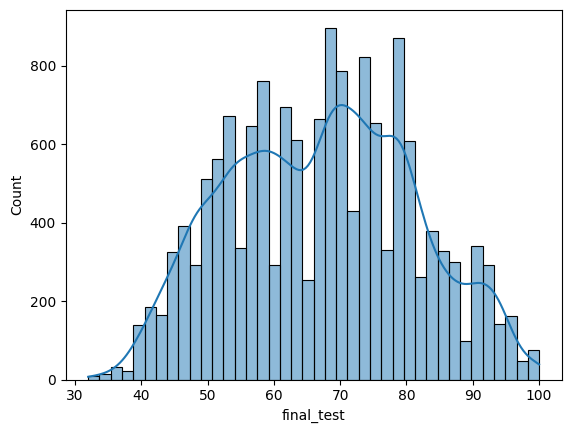

In [232]:
sns.histplot(data=data, x="final_test", bins=40, kde=True)
plt.show()

## Variable Types

To facilitate the exploration, we can group them into categorical and numerical variables
- For datetime, we will create a separate ``sleep_datetime`` and ``wake_datetime``, which is inclusive of the date, so that we can perform datetime subtraction to obtain number of sleeping hours later

In [233]:
# Categorical Variables
cat_vars = [var for var in data.columns if data[var].dtype == 'O' and 'time' not in var]

# Datetime Variables
data = (data
        .assign(
            sleep_datetime = lambda df_: pd.to_datetime(df_.sleep_time),
            wake_datetime = lambda df_: pd.to_datetime(df_.wake_time),
            sleep_time = lambda df_: pd.to_datetime(df_.sleep_time, format="%H:%M").dt.time,
            wake_time = lambda df_: pd.to_datetime(df_.wake_time, format="%H:%M").dt.time)
        )
date_vars = [var for var in data.columns if 'time' in var]

# Discrete Variables
discrete_vars = ['number_of_siblings']

# Numerical Variables
num_vars = [var for var in data.columns if data[var].dtype != 'O' \
            and var not in date_vars \
            and var not in discrete_vars \
            and var != 'final_test']

C:\Users\Joanna\AppData\Local\Temp\ipykernel_10044\2575532235.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sleep_datetime = lambda df_: pd.to_datetime(df_.sleep_time),
C:\Users\Joanna\AppData\Local\Temp\ipykernel_10044\2575532235.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  wake_datetime = lambda df_: pd.to_datetime(df_.wake_time),


In [234]:
cat_vars

['direct_admission',
 'CCA',
 'learning_style',
 'gender',
 'tuition',
 'mode_of_transport',
 'bag_color']

In [235]:
date_vars

['sleep_time', 'wake_time', 'sleep_datetime', 'wake_datetime']

In [236]:
discrete_vars

['number_of_siblings']

In [237]:
num_vars

['n_male', 'n_female', 'age', 'hours_per_week', 'attendance_rate']

## Missing Values

In [238]:
def percentage_missing(data):
    vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]
    count_of_missing = data[vars_with_na].isnull().sum()
    percentage_missing = data[vars_with_na].isnull().mean()
    table = pd.concat([count_of_missing, percentage_missing], axis=1)
    table = table.rename(columns={0: 'Count',
                                  1: 'Percentage'})
    return table

In [240]:
percentage_missing(data)

,Count,Percentage
final_test,495,0.031132
attendance_rate,778,0.048931


- There are approximately 3% of the values missing for ``final_test`` and 4% missing for ``attendance_rate``. 
- For ``final_test``, since this is our target variable, we are unable to perform any imputation as we don't want the model to learn the wrong information and thus we will drop these
- For ``attendance_rate``, let's see if there is a relationship between the missing data and our target variable

In [241]:
def analyse_na_value(data, var):
    data = data.copy()

    data[var] = np.where(data[var].isnull(), 0, 1)

    tmp = data.groupby(var)['final_test'].agg(['mean', 'std'])

    tmp.plot(kind='barh', y='mean', legend=False,
             xerr='std', title='Final Test', color='green')
    
    print(tmp)
    plt.show()

                      mean        std
attendance_rate                      
0                67.535007  14.277129
1                67.146300  13.962471


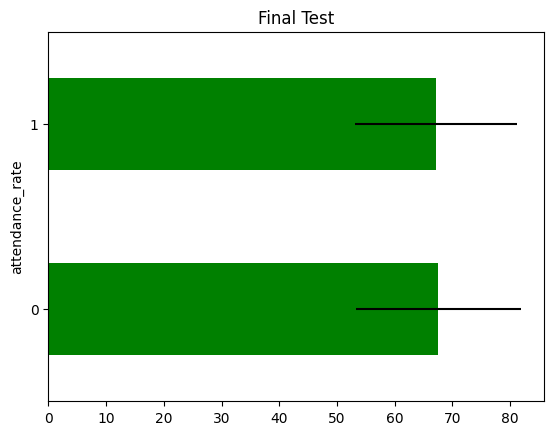

In [242]:
analyse_na_value(data, 'attendance_rate')

- There is no relationship between the missing values for ``attendance_rate`` and our target variable, hence we can safely drop them

In [243]:
data_no_missing = data[data['attendance_rate'].notna()]
data_no_missing = data_no_missing[data_no_missing['final_test'].notna()]

In [220]:
percentage_missing(data_no_missing)

,Count,Percentage


In [244]:
data_no_missing.shape

(14648, 18)

## Continuous Variables

In [221]:
num_vars

['n_male', 'n_female', 'age', 'hours_per_week', 'attendance_rate']

While the ``n_male`` and ``n_female`` will most likely not be a good predictor of the scores, we could combine them to get the ``total_class_size``

In [222]:
def compute_total_class_size(data):
    data = data.copy()
    data = data.assign(total_class_size = lambda df_: df_.n_male + df_.n_female)
    return data

In [223]:
def analyse_num_vars(data, var):
    data = data.copy()
    data = data.assign(total_class_size = lambda df_: df_.n_male + df_.n_female)
    
    var = var.copy()
    var.append('total_class_size')

    fig, ax = plt.subplots(2,3, figsize=(15, 8))
    row = 0
    for index, var_name in enumerate(var):
        if index > 2:
            row = 1
        col = index % 3
        sns.scatterplot(x=var_name, y='final_test', data=data, ax=ax[row,col])

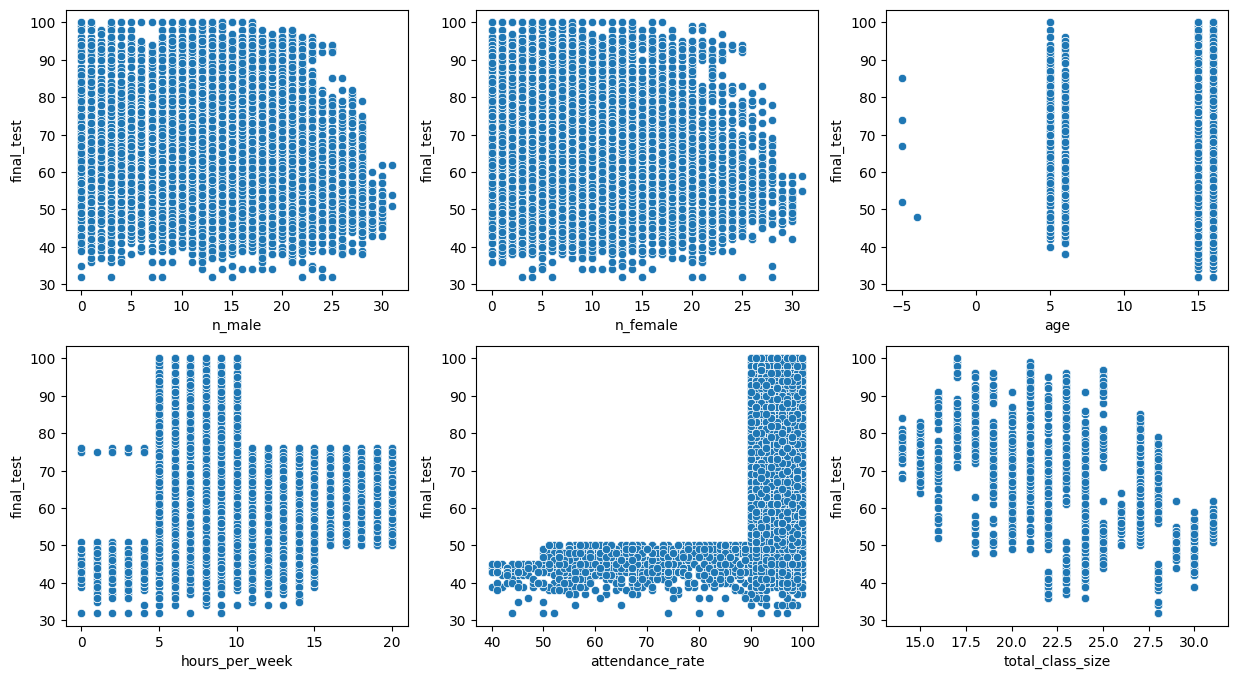

In [224]:
analyse_num_vars(data_no_missing, num_vars)

- There does not seem to be any relationship between ``n_male`` and ``n_female`` with the the test score as expected
- The newly created feature ``total_class_size`` suggests that students in smaller class size tend to score higher
- We also see that ``age`` had erroneous entries such as -5. While age 5 sitting for O Levels is not entirely impossible, given that there are so many of such entries, it is most likely a data entry error. 
- It is clear that students who has a ``high attendance`` are most likely to do well
- There are a few students who did relatively well just by spending only 0 to 5 ``hours_per_week`` 

Let's dig deeper into ``age``.
- Given that majority of the age is 15 and 16, it is most likely a data entry error (missing the first digit '1')

In [349]:
data_no_missing.age.value_counts()

age
 15.0    7117
 16.0    7112
 6.0      215
 5.0      199
-5.0        4
-4.0        1
Name: count, dtype: int64

The variables are not normally distributed. We can try transforming the variables to improve the value spread which in turn improves the model performance.

- The Yeo-Johnson transformation is a mathematical transformation used in statistics to stabilize variance and make data more closely approximate a normal distribution. It is a generalization of the Box-Cox transformation, which is used for a similar purpose but is limited to positive values. The Yeo-Johnson transformation extends the applicability to both positive and negative values, making it more versatile.

In [351]:
transform_var = ['n_male', 'n_female', 'hours_per_week', 'attendance_rate']

In [352]:
stats.yeojohnson(data_no_missing['attendance_rate'])

(array([1.24714291e+19, 1.73219603e+19, 1.39311511e+19, ...,
        1.55433150e+19, 1.73219603e+19, 1.24714291e+19]),
 10.2384536196288)

In [353]:
def analyse_transform_var(data, var):
    
    tmp = data_no_missing.copy()

    for var in transform_var:

        # transform the variable - yeo-johnson
        tmp[var], param = stats.yeojohnson(data_no_missing[var])
    
    tmp[transform_var].hist(bins=30,figsize=(10, 7))
    plt.show()

    return tmp


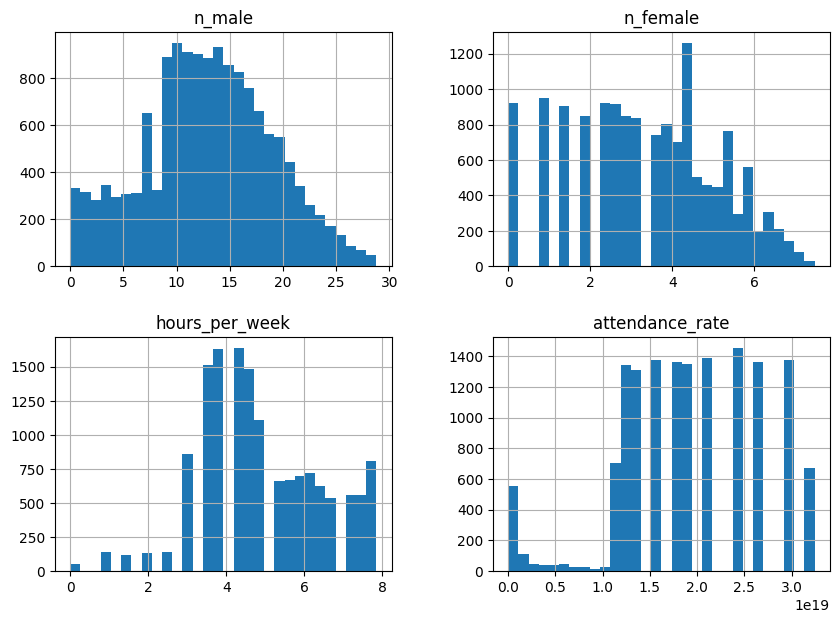

In [354]:
tmp = analyse_transform_var(data_no_missing, num_vars)

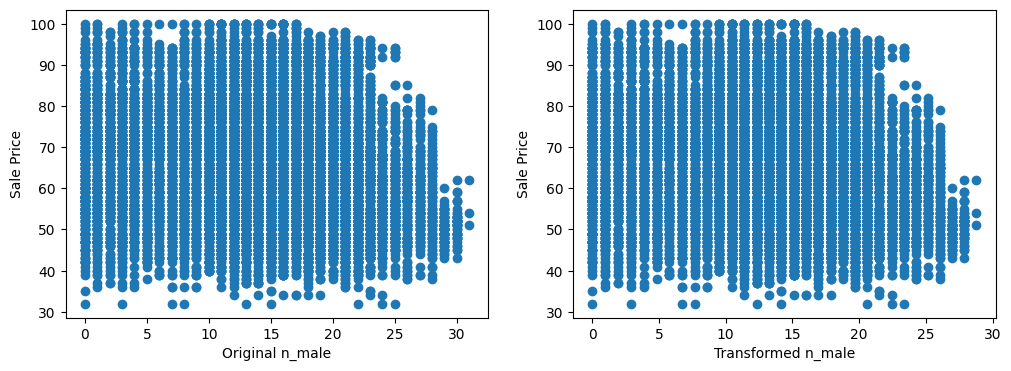

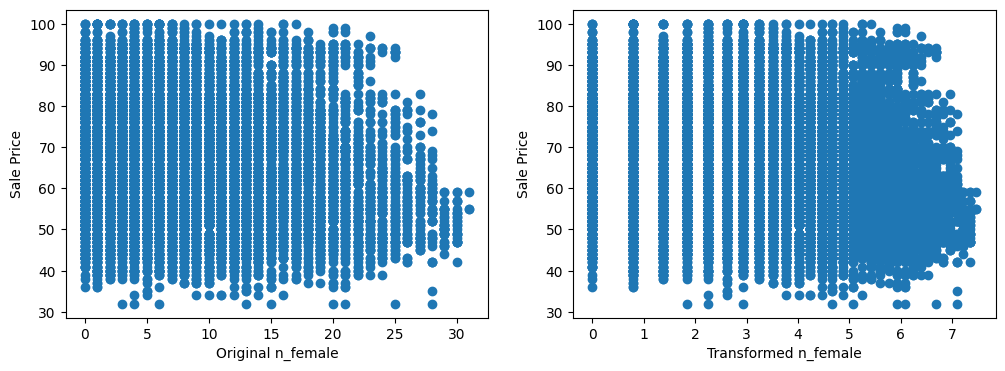

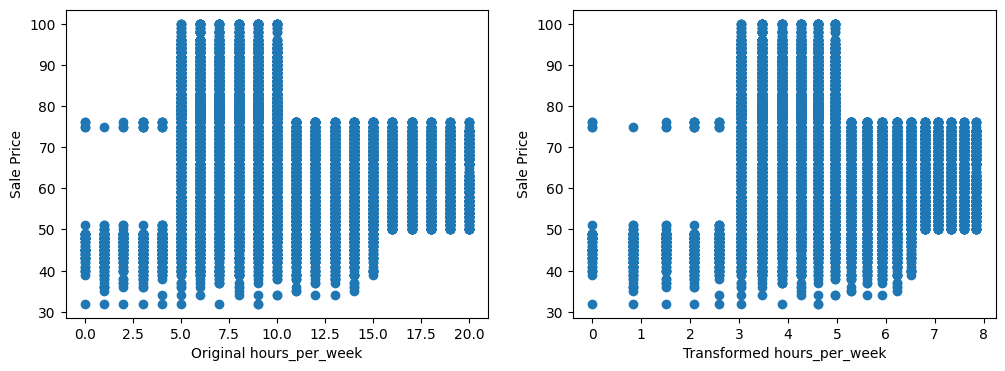

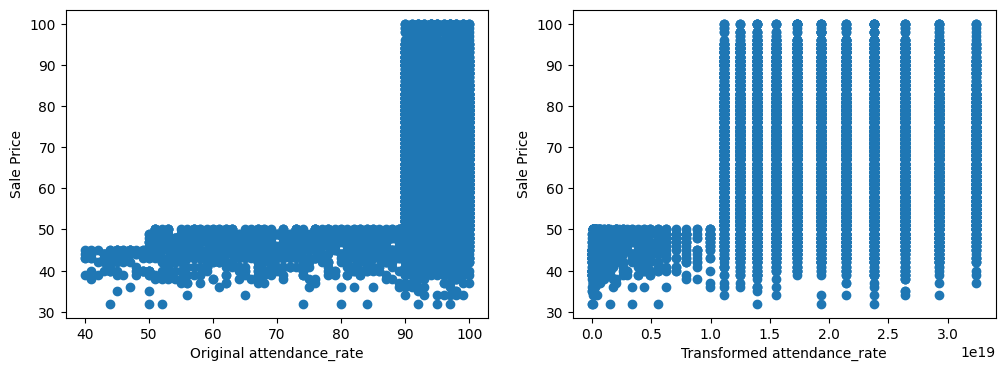

In [355]:
# let's plot the original or transformed variables
# vs sale price, and see if there is a relationship

for var in transform_var:
    
    plt.figure(figsize=(12,4))
    
    # plot the original variable vs sale price    
    plt.subplot(1, 2, 1)
    plt.scatter(data_no_missing[var], data_no_missing['final_test'])
    plt.ylabel('Sale Price')
    plt.xlabel('Original ' + var)

    # plot transformed variable vs sale price
    plt.subplot(1, 2, 2)
    plt.scatter(tmp[var], data_no_missing['final_test'])
    plt.ylabel('Sale Price')
    plt.xlabel('Transformed ' + var)
                
    plt.show()

- The transformed variables did not necessary led to better spread of values

## Discrete Variables

In [118]:
def analyse_discrete_var(data, var):
    sns.boxplot(x=var, y='final_test', data=data)
    sns.stripplot(x=var, y='final_test', data=data, jitter=0.04, alpha=0.03, color='k')
    plt.show()

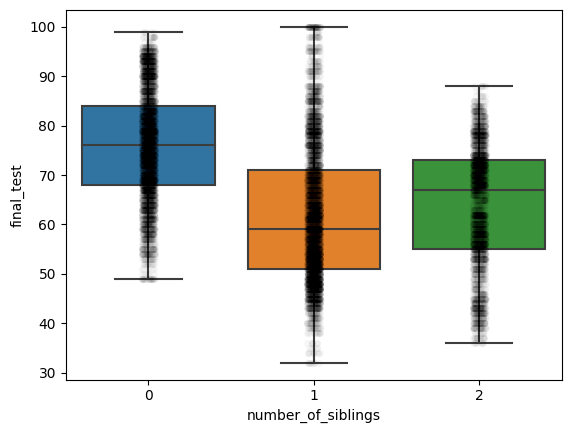

In [119]:
for var in discrete_vars:
    analyse_discrete_var(data_no_missing, var)

- Students with no siblings tend to perform better(?)

## Datetime Variables

In [226]:
def analyse_date_vars(data):

    data = data.copy()

    # get amount of sleep
    data = data.assign(sleeping_hours=lambda df_: (df_.wake_datetime - df_.sleep_datetime).dt.components.hours)

    # group by sleeping hours and get the mean test score
    sleep_hours_mean_score = data.groupby('sleeping_hours')['final_test'].agg(['mean']).reset_index()

    # plot
    sleep_hours_mean_score.plot(x='sleeping_hours', y='mean')
    plt.xlabel("Sleeping Hours")
    plt.ylabel("Final Test")
    plt.show()

It is clear that students score better when they have more sleep. This feature will no doubt help in building the model for prediction

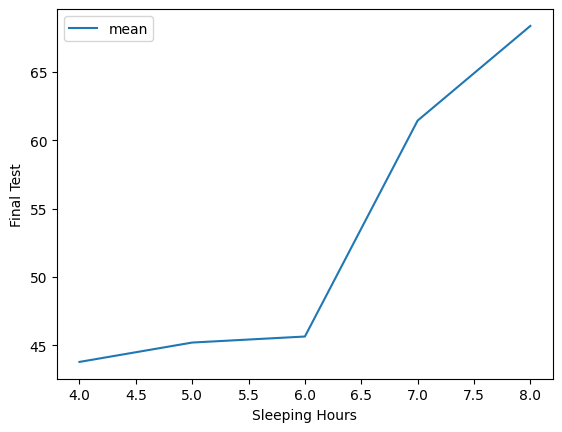

In [227]:
analyse_date_vars(data_no_missing)

In [228]:
data_no_missing.head()

,number_of_siblings,direct_admission,CCA,learning_style,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color,sleep_datetime,wake_datetime
0,0,Yes,Sports,Visual,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00:00,06:00:00,private transport,yellow,2023-09-07 22:00:00,2023-09-07 06:00:00
1,2,No,Sports,Auditory,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30:00,06:30:00,private transport,green,2023-09-07 22:30:00,2023-09-07 06:30:00
2,0,Yes,None,Visual,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30:00,06:30:00,private transport,white,2023-09-07 22:30:00,2023-09-07 06:30:00
4,0,No,Sports,Auditory,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30:00,05:30:00,public transport,yellow,2023-09-07 21:30:00,2023-09-07 05:30:00
5,0,No,Arts,Visual,Female,No,57.0,9.0,12.0,15.0,11.0,96.0,22:30:00,06:30:00,private transport,red,2023-09-07 22:30:00,2023-09-07 06:30:00


## Categorical Variables

In [141]:
def check_cardinality(data, var):
    data = data.copy()

    # get cardinality
    num_unique = data[var].nunique()
    unique_labels = data[var].unique()

    print(f"Column: {var} \n Number of unique labels: {num_unique} \n Unique Labels: {unique_labels}")

In [142]:
for var in cat_vars:
    check_cardinality(data_no_missing, var)

Column: direct_admission 
 Number of unique labels: 2 
 Unique Labels: ['Yes' 'No']
Column: CCA 
 Number of unique labels: 8 
 Unique Labels: ['Sports' 'None' 'Arts' 'ARTS' 'Clubs' 'SPORTS' 'CLUBS' 'NONE']
Column: learning_style 
 Number of unique labels: 2 
 Unique Labels: ['Visual' 'Auditory']
Column: gender 
 Number of unique labels: 2 
 Unique Labels: ['Female' 'Male']
Column: tuition 
 Number of unique labels: 4 
 Unique Labels: ['No' 'Yes' 'Y' 'N']
Column: mode_of_transport 
 Number of unique labels: 3 
 Unique Labels: ['private transport' 'public transport' 'walk']
Column: bag_color 
 Number of unique labels: 6 
 Unique Labels: ['yellow' 'green' 'white' 'red' 'blue' 'black']


- For ``CCA``, we have to perform some text processing as there are repeated labels of different format
- For ``tuition``, we have to also perform similar text processing as the labels are in different format

In [150]:
def clean_cardinality(data):
    data = data.copy()

    tuition_mappings = {'Y': 'Yes', 'Yes': 'Yes', 'N': 'No', 'No': 'No'}
    data = (data
            .assign(CCA=lambda df_: df_.CCA.str.title(),
                    tuition=lambda df_: df_.tuition.map(tuition_mappings))
    )
    return data

In [151]:
clean_data_no_missing = clean_cardinality(data_no_missing, cat_vars)

In [152]:
for var in cat_vars:
    check_cardinality(clean_data_no_missing, var)

Column: direct_admission 
 Number of unique labels: 2 
 Unique Labels: ['Yes' 'No']
Column: CCA 
 Number of unique labels: 4 
 Unique Labels: ['Sports' 'None' 'Arts' 'Clubs']
Column: learning_style 
 Number of unique labels: 2 
 Unique Labels: ['Visual' 'Auditory']
Column: gender 
 Number of unique labels: 2 
 Unique Labels: ['Female' 'Male']
Column: tuition 
 Number of unique labels: 2 
 Unique Labels: ['No' 'Yes']
Column: mode_of_transport 
 Number of unique labels: 3 
 Unique Labels: ['private transport' 'public transport' 'walk']
Column: bag_color 
 Number of unique labels: 6 
 Unique Labels: ['yellow' 'green' 'white' 'red' 'blue' 'black']


In [185]:
def analyse_cat_vars(data, var):
    data = data.copy()
    fig, ax = plt.subplots(2,4, figsize=(15,8))

    row = 0
    for index, var_name in enumerate(var):
        col = index % 4
        if index > 3:
            row = 1
        sns.boxplot(x=var_name, y='final_test', data=data, ax=ax[row, col])
        sns.stripplot(x=var_name, y='final_test', data=data, jitter=0.04, alpha=0.03, color='k', ax=ax[row,col])

In [245]:
clean_data_no_missing.CCA.value_counts()

CCA
Clubs     3753
Sports    3652
None      3634
Arts      3609
Name: count, dtype: int64

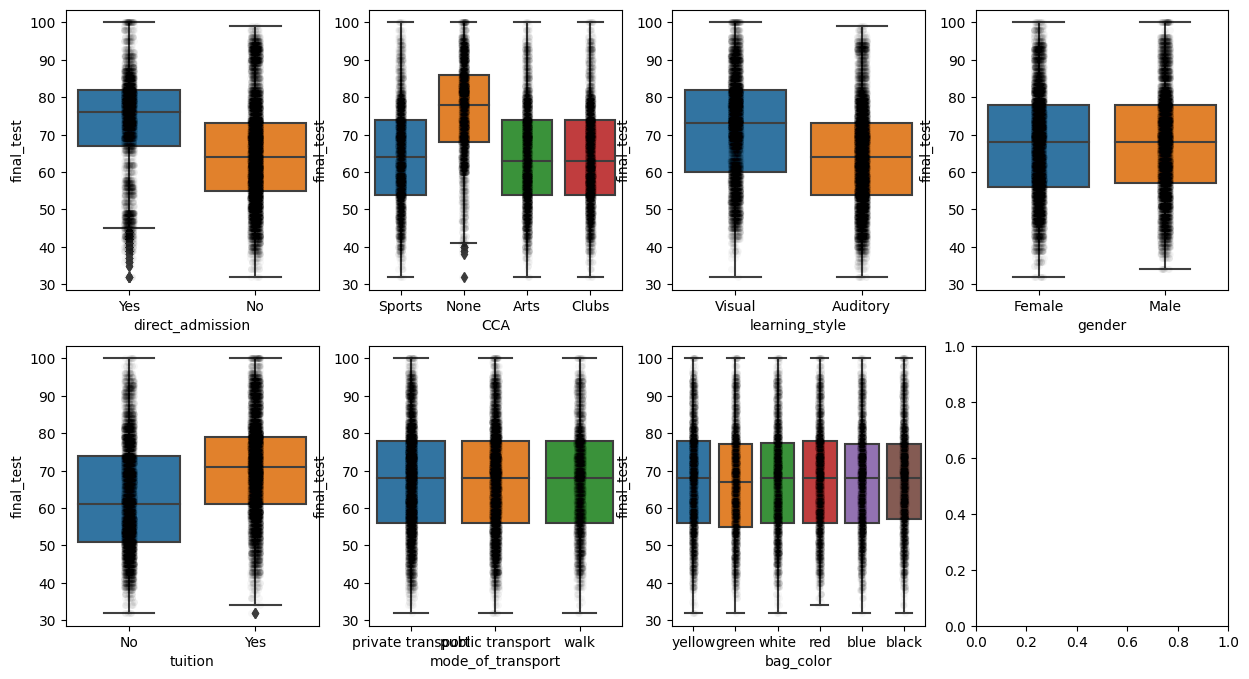

In [186]:
analyse_cat_vars(clean_data_no_missing, cat_vars)

- There is no difference in the scores for different categories of ``gender``, ``mode_of_transport`` and ``bag_color``. As such, we can exclude them in our model since they do not contribute to the prediction
- For ``CCA``, since Sports, Arts and Clubs in general have the approximately similar test scores, we can perhaps re-label ``CCA`` into just yes or no to cut down on the number of cardinality.
- From ``direct_admission``, students who are admitted directly tend to score higher
- From ``learning_style``, visual students tend to score higher as compared to auditory
- From ``tuition``, students who has tuition tend to score higher